## Load the Data

### 1.1. Load the data

In [16]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import tensorflow as tf
import urllib.request, json
import os

from math import sqrt
from sklearn.metrics import mean_squared_error
from pandas_datareader import data
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from statsmodels.tsa.arima.model import ARIMA

In [17]:
df=pd.read_csv('../data/us_disaster_declarations.csv')

### 1.2. Clean States

In [18]:
# Clean states / remove territories 
mainland_states = ["AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DE", "FL", "GA", 
                   "HI", "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD", 
                   "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ", 
                   "NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC", 
                   "SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY"]

df=df[df['state'].isin(mainland_states)]

### 1.3. Date Encoding / Clean Columns / Clean Incident Types

In [19]:
# Create 'incident_dtm' column to convert 'incident_begin_date' obj to datetime
df['incident_dtm']=pd.to_datetime(df['incident_begin_date'], format='%Y-%m-%dT%H:%M:%SZ')

# Remove unneeded columns / create subset_df with reformatted 'incident_dtm', 'incident_type', and 'state'
subset_df=df[['incident_dtm', 'incident_type', 'state']]

subset_df.set_index('incident_dtm', inplace=True)

subset_df.head()

incident_type state
incident_dtm                    
1953-05-02         Tornado    GA
1953-05-15         Tornado    TX
1953-05-29           Flood    LA
1953-06-02         Tornado    MI
1953-06-06           Flood    MT

### 1.4. TEST Model

/tmp/ipykernel_11324/3410975933.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_disasters = subset_df.resample('M').size()


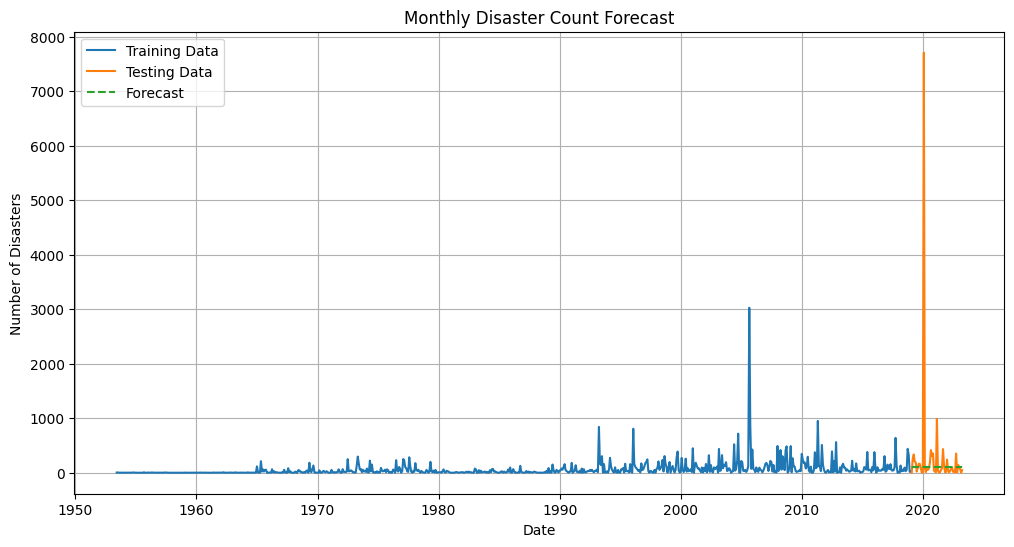

Root Mean Squared Error: 1077.3335696259824


In [20]:
# Monthly aggregation and "no disaster" feature
monthly_disasters = subset_df.resample('M').size()
monthly_disasters_df = monthly_disasters.to_frame(name='disaster_count')
monthly_disasters_df['no_disaster'] = monthly_disasters_df['disaster_count'].apply(lambda x: 1 if x == 0 else 0)

# Train-test split
split_date = '2019-01-01'
train = monthly_disasters_df[:split_date]['disaster_count']
test = monthly_disasters_df[split_date:]['disaster_count']

# ARIMA model
model = ARIMA(train, order=(1, 1, 1))
model_fit = model.fit()
forecast = model_fit.forecast(steps=len(test))

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Training Data')
plt.plot(test.index, test, label='Testing Data')
plt.plot(test.index, forecast, label='Forecast', linestyle='--')
plt.title('Monthly Disaster Count Forecast')
plt.xlabel('Date')
plt.ylabel('Number of Disasters')
plt.legend()
plt.grid()
plt.show()

# Evaluate model
rmse = np.sqrt(mean_squared_error(test, forecast))
print(f"Root Mean Squared Error: {rmse}")

### 1.4. Disaster Encoding

In [11]:
# Encode the disaster types to dummies
disaster_dummies=pd.get_dummies(subset_df['incident_type'], dtype=int)

disaster_dummies.head()

Biological  Chemical  Coastal Storm  Dam/Levee Break  Drought  Earthquake  \
0           0         0              0                0        0           0   
1           0         0              0                0        0           0   
2           0         0              0                0        0           0   
3           0         0              0                0        0           0   
4           0         0              0                0        0           0   

   Fire  Fishing Losses  Flood  Freezing  ...  Severe Storm  Snowstorm  \
0     0               0      0         0  ...             0          0   
1     0               0      0         0  ...             0          0   
2     0               0      1         0  ...             0          0   
3     0               0      0         0  ...             0          0   
4     0               0      1         0  ...             0          0   

   Terrorist  Tornado  Toxic Substances  Tropical Storm  Tsunami  Typhoon  \
0          0        1                 0               0        0        0   
1          0        1                 0               0        0        0   
2          0        0                 0               0        0        0   
3          0        1                 0               0        0        0   
4          0        0                 0               0        0        0   

   Volcanic Eruption  Winter Storm  
0                  0             0  
1                  0             0  
2                  0             0  
3                  0             0  
4                  0             0  

[5 rows x 25 columns]

In [12]:
# Combine disaster dummies and subset_df, remove 'incident_type' column
subset_df=pd.concat([subset_df.reset_index(drop=True), disaster_dummies.reset_index(drop=True)], axis=1)
subset_df.drop('incident_type', axis=1, inplace=True)
subset_df.head()

incident_dtm state  Biological  Chemical  Coastal Storm  Dam/Levee Break  \
0   1953-05-02    GA           0         0              0                0   
1   1953-05-15    TX           0         0              0                0   
2   1953-05-29    LA           0         0              0                0   
3   1953-06-02    MI           0         0              0                0   
4   1953-06-06    MT           0         0              0                0   

   Drought  Earthquake  Fire  Fishing Losses  ...  Severe Storm  Snowstorm  \
0        0           0     0               0  ...             0          0   
1        0           0     0               0  ...             0          0   
2        0           0     0               0  ...             0          0   
3        0           0     0               0  ...             0          0   
4        0           0     0               0  ...             0          0   

   Terrorist  Tornado  Toxic Substances  Tropical Storm  Tsunami  Typhoon  \
0          0        1                 0               0        0        0   
1          0        1                 0               0        0        0   
2          0        0                 0               0        0        0   
3          0        1                 0               0        0        0   
4          0        0                 0               0        0        0   

   Volcanic Eruption  Winter Storm  
0                  0             0  
1                  0             0  
2                  0             0  
3                  0             0  
4                  0             0  

[5 rows x 27 columns]

### 1.5. Time Axis Regularization/Resampling

In [15]:
def sum_months(group: pd.DataFrame) -> pd.DataFrame:
    '''Takes a yearly groupby object and sums features over months'''

    group=group.resample('ME').sum()

    return group

def resample_months(group: pd.DataFrame) -> pd.DataFrame:
    '''Takes working dataframe and resamples frequency to months.
    Returns updated dataframe'''

    # Set 'incident_dtm' as datetime axis
    group=group.set_index('incident_dtm')

    # Sum disasters in each month by year; removes duplicates where there was more than one disaster in a month
    group=group.groupby(group.index.year, group_keys=False).apply(sum_months)

    # Resample to monthly frequency
    group=group.resample('D').asfreq()

    # Fill missing values with 0
    group=group.fillna(0)

    # Convert everything to int
    group=group.astype(bool)

    # Reset the index, preserving the `incident_dtm`
    group.reset_index(inplace=True, drop=False)

    return group

# Use resampling function on subset_df
resampled_df=subset_df.groupby('state', group_keys=True).apply(resample_months, include_groups=False)

resampled_df.head(10)

incident_dtm  Biological  Chemical  Coastal Storm  Dam/Levee Break  \
state                                                                        
AK    0   1953-10-31       False     False          False            False   
      1   1953-11-01       False     False          False            False   
      2   1953-11-02       False     False          False            False   
      3   1953-11-03       False     False          False            False   
      4   1953-11-04       False     False          False            False   
      5   1953-11-05       False     False          False            False   
      6   1953-11-06       False     False          False            False   
      7   1953-11-07       False     False          False            False   
      8   1953-11-08       False     False          False            False   
      9   1953-11-09       False     False          False            False   

         Drought  Earthquake   Fire  Fishing Losses  Flood  ...  Severe Storm  \
state                                                       ...                 
AK    0    False       False  False           False  False  ...         False   
      1    False       False  False           False  False  ...         False   
      2    False       False  False           False  False  ...         False   
      3    False       False  False           False  False  ...         False   
      4    False       False  False           False  False  ...         False   
      5    False       False  False           False  False  ...         False   
      6    False       False  False           False  False  ...         False   
      7    False       False  False           False  False  ...         False   
      8    False       False  False           False  False  ...         False   
      9    False       False  False           False  False  ...         False   

         Snowstorm  Terrorist  Tornado  Toxic Substances  Tropical Storm  \
state                                                                      
AK    0      False      False    False             False           False   
      1      False      False    False             False           False   
      2      False      False    False             False           False   
      3      False      False    False             False           False   
      4      False      False    False             False           False   
      5      False      False    False             False           False   
      6      False      False    False             False           False   
      7      False      False    False             False           False   
      8      False      False    False             False           False   
      9      False      False    False             False           False   

         Tsunami  Typhoon  Volcanic Eruption  Winter Storm  
state                                                       
AK    0    False    False              False         False  
      1    False    False              False         False  
      2    False    False              False         False  
      3    False    False              False         False  
      4    False    False              False         False  
      5    False    False              False         False  
      6    False    False              False         False  
      7    False    False              False         False  
      8    False    False              False         False  
      9    False    False              False         False  

[10 rows x 26 columns]